 JascoのFPによる三次元 (励起-蛍光-強度) 蛍光測定を可視化して保存するスクリプトです。2020/11/10 Shogen MATSUMOTO
- 3つのセルに分かれており：(1) データ読み込み & マッピング, (2) 特定励起波長における蛍光発光スペクトル, (3) 特定蛍光波長における励起スペクトル：となっています。
- (1) を使わずに (2)-(3) を実行することはできません。いったん (1) を実行した後は、(2)や(3)は何度でも実行できます (やりなおせます)。
- ブロードな蛍光ピークを見るときには、これらのマッピング測定による議論の方がわかりやすいです。
- また、絶対的な蛍光量が弱いときに出てくる、二倍光についても確認しやすいです。
- 20201201 - 書き出した蛍光&励起スペクトルのテキストデータを保存できるように編集 松本

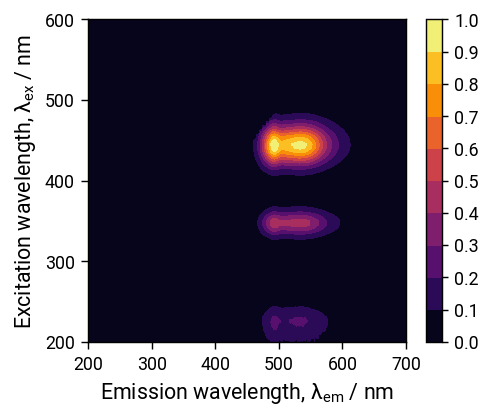

In [2]:
##指紋スペクトルのプロット # 20201110
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm

## 図表の最大最小
x_plt_min, x_plt_max, x_plt_div = 200, 700, 100 # / nm (emission)
y_plt_min, y_plt_max, y_plt_div = 200, 600, 100# / nm (exitation)
I_plt_max = 1.0 # 最大Intに対するheatmapの最大値 (1.0が最大値)
div = 11 #等高線図の分割数
vmin = 0.0 #描画する値の最小値
vmax = 1.0 #描画する値の最大値
file_name_No = -25 # タイトルに表示するファイル名をスライスする用の番号 (-25から-18くらい)

# Display a file dialog
import os, tkinter, tkinter.filedialog, tkinter.messagebox
root = tkinter.Tk()
root.attributes('-topmost', True)
root.withdraw()
root.lift()
root.focus_force()
fTyp = [("","*.txt")]
file = tkinter.filedialog.askopenfilename(filetypes = fTyp)
%gui tk
 
#データの読み込みとインデックスの指定、データ形式の指定
df = pd.read_table(file, skiprows = 17).set_index("Unnamed: 0", drop=False).astype("float64")
#df.loc['200.0'] = df.loc['210.0']
try:
    df.loc[200.0] = df.loc[210.0]
    df = df.sort_index(axis='index')
except:
    print("pass")    

#Queryによるデータフレームのx軸絞り込み&転置
df1 = df[(df["Unnamed: 0"] >= float(x_plt_min)) & (df["Unnamed: 0"] <= float(x_plt_max))].drop('Unnamed: 0', axis=1).T
#転置後のインデックスをfloat化&絞り込み
df1.index = df1.index.astype("float64")
df1 = df1[(df1.index >= float(y_plt_min)) & (df1.index <= float(y_plt_max))]

# 最小値が負の場合、それを全要素に足して0基準にしたのち、1.0に規格化
Int_min = df1.min().min()
def Baseline(x):
    if Int_min < 0:
        return x - Int_min + 0.1
    else:
        return x
df1 = Baseline(df1)
Int_max = df1.max().max()
def Normalize(x):
    return x/Int_max/I_plt_max
df1 = Normalize(df1)

## このセルでは使わないけど励起スペクトルや蛍光スペクトル個別書き出し用のDefault plot設定
def Default_plot(x, y, x_min, x_max, y_min, y_max, y_aspect):
    # True Type font setting
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42

    params = {'mathtext.default':'regular'} # 軸ラベルにおける数式の非斜体化
    fig1, ax1 = plt.subplots(figsize=(85/25.48, 85/25.48/y_aspect), dpi=128) #サイズ調整
    #ax2=ax1.twiny() #Right軸の設定 ##legendの個別設定ができなくなる
    plt.rcParams["font.size"] = 12
    plt.rcParams['axes.linewidth'] = 1.2 # 外枠太さの調整
    plt.rcParams["font.family"] = "Roboto-Regular"
    plt.rcParams["font.weight"] = "regular"
    # 軸の設定
    plt.rcParams['xtick.major.width'] = 1.2 #x軸主目盛り線の線幅
    plt.rcParams['ytick.major.width'] = 1.2 #y軸主目盛り線の線幅
    plt.tick_params(direction = "in", length=6)

    plt.tick_params('x', direction = "in", length=6) # メモリ対象をX軸のみに
    plt.tick_params('y', length=0, color="None") # Y軸目盛を非表示に
    plt.yticks(color="None") # Y軸の数値を非表示に
    ax1.yaxis.set_label_coords(-0.03,0.5) # 軸の位置を固定, グラフの原点からの位置
    ax1.tick_params(which ="minor",direction = 'in' ,axis="both", length = 0 ,width = 0) # minor ticksの非表示

    params = {'mathtext.default':'regular'} # 軸ラベルにおける数式の非斜体化
    ax1.set_xlabel("Wavelength, λ / nm")
    ax1.set_ylabel("Intensity (arb. unit)")
    plt.xlim(x_min,x_max)
    plt.xticks(np.arange(x_min, x_max+0.01, 100)) #X軸の目盛り設定
    plt.ylim(y_min, y_max)
    #ax2.set_xlim(1000/x_min,1000/x_max)
    #plt.title(file[file_name_No:-4])
    ax1.plot(x, y, color="b", linewidth=1.2)
df = Normalize(Baseline(df)) # 切り取ってないdfのノーマライズ化
## このセルに関係ない部分おわり

# True Type font setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(85/25.48*1.20, 85/25.48), dpi=128)
params = {'mathtext.default':'regular'} # 軸ラベルにおける数式の非斜体化
plt.rcParams.update(params)
plt.rcParams['font.family']="Roboto-Regular"
plt.xlabel("Emission wavelength, $λ_{em}$ / nm",fontsize=12, fontname="Roboto-Regular", fontweight="regular")
plt.ylabel("Excitation wavelength, $λ_{ex}$ / nm",fontsize=12, fontname="Roboto-Regular", fontweight="regular")
plt.tick_params(direction = "out", length=4)
plt.xlim(x_plt_min, x_plt_max)
plt.xticks(np.arange(x_plt_min, x_plt_max+0.01, x_plt_div)) #X軸の目盛り設定
plt.ylim(y_plt_min, y_plt_max)
plt.yticks(np.arange(y_plt_min, y_plt_max+0.01, y_plt_div)) #X軸の目盛り設定

x = df1.columns
y = df1.index
z = df1.values
bounds = np.linspace(vmin, vmax, div, endpoint=True)
fig = plt.contourf(x, y, z, bounds, vmin=vmin, vmax=vmax, alpha=1.0, cmap="inferno", linestyles=None) # 白黒対応のため
cbar = plt.colorbar(fig, ticks=bounds, orientation="vertical")
#plt.title(file[file_name_No:-4])

plt.savefig((f'{file}-PL-PLE-contour-em{x_plt_min}-{x_plt_max}_ex{y_plt_min}-{y_plt_max}nm.pdf'), bbox_inches="tight")

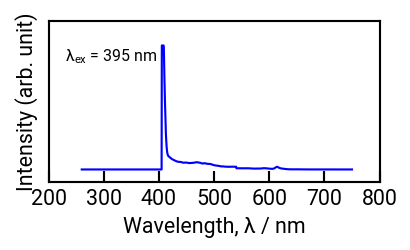

In [5]:
# 個別PLスペクトルの書き出し
ex_w = "395" ## 書き出したい蛍光スペクトルの励起波長
em_x_min = 200 ##書き出す蛍光スペクトルの最小x
em_x_max = 800 ##書き出す蛍光スペクトルの最大x
norm_em = True

em_x_len = em_x_max-em_x_min
em_y_min = -0.1 ##書き出す蛍光スペクトルの最小y -0.1
em_y_max = 1.2 ##書き出す蛍光スペクトルの最大y 1.2
em_y_aspect = 2.0


em_x=df[ex_w].index
em_y=df[ex_w].values
if norm_em:    
    em_y_max = em_y.max()
    em_y = em_y/em_y_max
    Default_plot(em_x, em_y, em_x_min, em_x_max, -0.1, 1.2, em_y_aspect)
else:
    Default_plot(em_x, em_y, em_x_min, em_x_max, em_y_min, em_y_max, em_y_aspect)
plt.text(em_x_min+0.05*em_x_len, em_y_max-0.12*em_y_max, "$λ_{ex}$ = "+f"{ex_w}"+" nm", fontsize=9)

## 書き出しデータの保存
df[ex_w].to_csv(f'{file}-PL-ex={ex_w}.txt', header=False, sep="\t")
## グラフの保存
plt.savefig((f'{file}-PL-ex={ex_w}.pdf'), bbox_inches="tight")

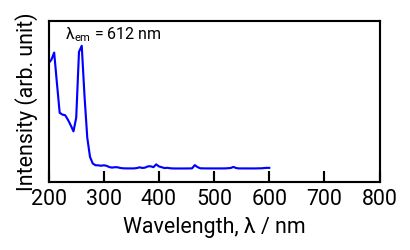

In [3]:
# 個別PLEスペクトルの書き出し
em_w = 612 ## 書き出したい励起スペクトルの蛍光波長
ex_x_min = 200 ##書き出す蛍光スペクトルの最小x
ex_x_max = 800 ##書き出す蛍光スペクトルの最大x
ex_x_len = ex_x_max-ex_x_min
ex_y_min = -0.1 ##書き出す蛍光スペクトルの最小y -0.1
ex_y_max = 1.2 #書き出す蛍光スペクトルの最大y 1.2
ex_y_len = ex_y_max - ex_y_min
ex_y_aspect = 2.0

df2 = df.drop('Unnamed: 0', axis=1).T #PLE用の転置したDf作成
ex_x=df2[em_w].index.astype("float64")
ex_y=df2[em_w].values
Default_plot(ex_x, ex_y, ex_x_min, ex_x_max, ex_y_min, ex_y_max, ex_y_aspect)
plt.text(ex_x_min+0.05*ex_x_len, ex_y_max-0.12*ex_y_max, "$λ_{em}$ = "+f"{em_w}"+" nm", fontsize=9)

## 書き出しデータの保存
df2[em_w].to_csv(f'{file}-PL-ex={em_w}.txt', header=False, sep="\t")
## グラフの保存
plt.savefig((f'{file}-PEL-ex={em_w}.pdf'), bbox_inches="tight")

no
